Import Library

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Load Dataset

In [24]:
data = pd.read_csv('netflixSubscriptions.csv')
print(data.head())

  Time Period  Subscribers
0  01/04/2013     34240000
1  01/07/2013     35640000
2  01/10/2013     38010000
3  01/01/2014     41430000
4  01/04/2014     46130000


In [25]:
print(data.describe())

        Subscribers
count  4.200000e+01
mean   1.304243e+08
std    6.891896e+07
min    3.424000e+07
25%    6.722500e+07
50%    1.216250e+08
75%    2.015325e+08
max    2.383900e+08


Data Pre-processing

In [26]:
# Handling Missing Values
print(data.isnull().sum())

Time Period    0
Subscribers    0
dtype: int64


In [27]:
# Data Type Conversion
data['Time Period'] = pd.to_datetime(data['Time Period'], format='%d/%m/%Y')
print(data.head())

  Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000


In [28]:
# Handling Duplicate Data
data.drop_duplicates(inplace=True)

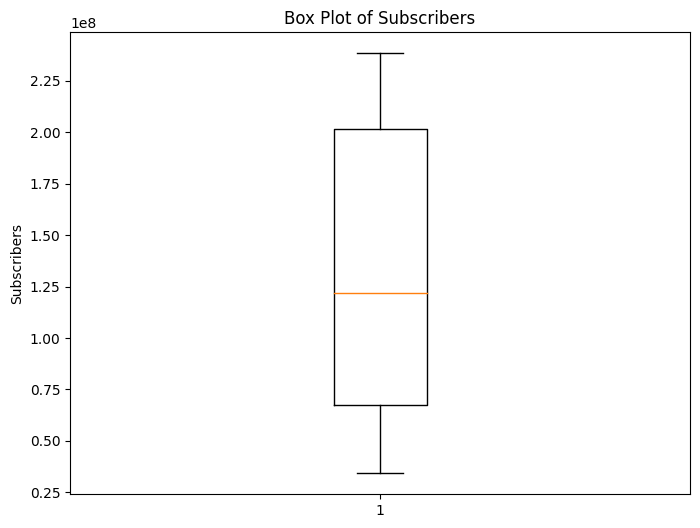

In [29]:
# Handling Outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data['Subscribers'])
plt.ylabel('Subscribers')
plt.title('Box Plot of Subscribers')
plt.show()

In [30]:
# Feature Engineering (Extracting Year, Quarter, Month)
data['Year'] = data['Time Period'].dt.year
data['Quarter'] = data['Time Period'].dt.quarter
data['Month'] = data['Time Period'].dt.month

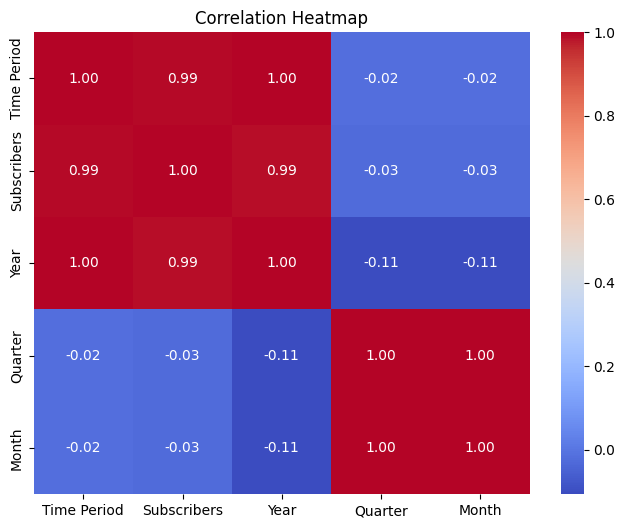

In [31]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [32]:
# Data Normalization (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Scaled_Subscribers'] = scaler.fit_transform(data[['Subscribers']])

Visualization and Correlation

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Time Period'],
                         y=data['Subscribers'],
                         mode='lines', name='Subscribers'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='Netflix Subscriptions')
fig.show()

In [67]:
# Calculate the quarterly growth rate
data['Quarterly Growth Rate'] = data['Subscribers'].pct_change() * 100

# Orange for positive growth, red for negative growth
data['Bar Color'] = data['Quarterly Growth Rate'].apply(lambda x: 'orange' if x > 0 else 'red')

# Plotting
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Time Period'],
    y=data['Quarterly Growth Rate'],
    marker_color=data['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()

In [65]:
# Orange for positive growth, red for negative growth
data['Bar Color'] = yearly_growth.apply(lambda x: 'orange' if x > 0 else 'red')

# Plotting
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Year'],
    y=yearly_growth,
    marker_color=data['Bar Color'],
    name='Yearly Growth Rate'
))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)')
fig.show()

Using ARIMA to forecast the number of subscriptions of Netflix

In [48]:
time_series = data.set_index('Time Period')['Subscribers']

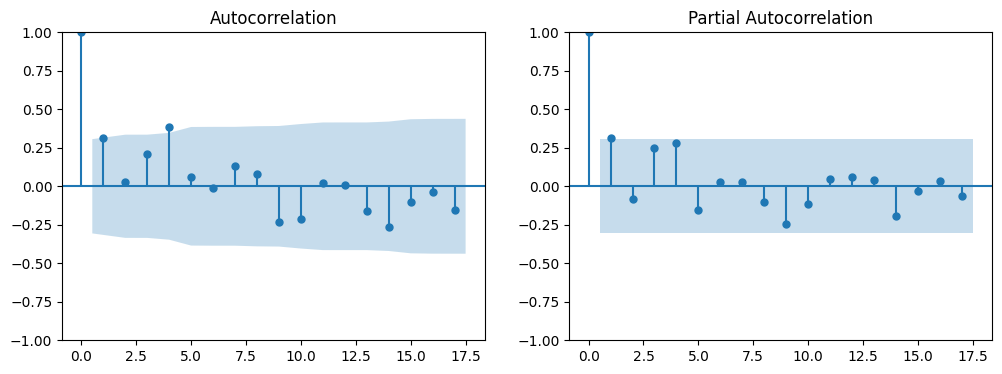

In [49]:
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

ARIMA Model

In [50]:
p, d, q = 1, 1, 1
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Sat, 28 Sep 2024   AIC                           1351.986
Time:                        11:22:04   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.765      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

In [51]:
# Train model
future_steps = 5
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)

In [55]:
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

Result

In [68]:
# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  title_x=0.5,
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()